## Quality Metrics


This notebook is used to visualize the spike sorting quality metrics using the metrics.csv generated from kilosort. 

If you are new to using DataJoint for array electrophysiology - please see our [tutorial](./tutorial.ipynb) notebook for an in-depth explanation for setting up and running the DataJoint Workflow for NeuroPixels electrophysiology.

The Element also offers Quality Metric visualizations. These are generated using `metrics.csv` generated from kilosort.

In [1]:
import datajoint as dj
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from workflow_array_ephys.pipeline import ephys

[2023-04-19 18:07:13,324][WARNING]: lab.Project and related tables will be removed in a future version of Element Lab. Please use the project schema.
[2023-04-19 18:07:13,330][INFO]: Connecting root@fakeservices.datajoint.io:3306
[2023-04-19 18:07:13,336][INFO]: Connected root@fakeservices.datajoint.io:3306


First, ensure your `QualityMetrics` table is populated with this data:

In [2]:
ephys.QualityMetrics.populate()

### Unit quality metrics

#### Histograms of the following cluster metrics will be plotted. 

- `Firing rates (Hz)`: Total number of spikes / time in seconds 

- `SNR (Signal-to-noise ratio)`: The ratio of the maximum amplitude of the mean spike waveform to the standard deviation of the background noise on a given channel.

- `Presence ratio`: The proportion of time during a session that a unit is spiking, ranging from 0 to 0.99.

- `ISI (Interspike Interval) violation`: The rate of ISI violation as a fraction of overall rate.

- `Number violation`: The total number of ISI violations.

- `Amplitude cut-off`: The false negative rate of a unit measured by the degree to which its distribution of spike amplitudes is truncated, indicating the fraction of missing spikes. An amplitude cutoff of 0.1 indicates approximately 10% missing spikes.

- `Isolation distance`: A metric that uses the principal components (PCs) of a unit's waveforms, which are projected into a lower-dimensional PC space after spike sorting. This quantifies how well-isolated the unit is from other potential clusters.

- `L-ratio`: A metric to quantify the distribution of spike distances from a cluster. A low L-ratio indicates that there is a relatively low number of non-member spikes around the target cluster. 

- `d-prime`: A metric calculated from waveform principal components using linear discriminant analysis. This measures the separability of one unit's PC cluster from all the others, with a higher d-prime value indicating better isolation of the unit.

- `Nearest-Neighbor Hit Rate`: The proportion of its nearest neighbors that belong to the same given cluster based on its first principal components.

- `Nearest-Neighbor Miss Rate`: The proportion of its nearest neighbors that do not belong to the same given cluster based on its first principal components.

- `Silhouette Score`: The ratio between cohesiveness of a cluster (distance between member spikes) and its separation from other clusters (distance to non-member spikes).

- `Max Drift`: The maximum shift in spike location, calculated as the center of mass of the energy of the first principal component score.

#### For more detailed explanation, please visit the following references:
- https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html

- https://elifesciences.org/articles/61834

We'll grab an example key for demonstration.


In [2]:
key = {"subject": "subject5", "insertion_number": 1}

query = ephys.QualityMetrics.Cluster & key
query

subject,session_datetime,insertion_number,paramset_idx,curation_id,unit,firing_rate (Hz) firing rate for a unit,snr signal-to-noise ratio for a unit,presence_ratio fraction of time in which spikes are present,isi_violation rate of ISI violation as a fraction of overall rate,number_violation total number of ISI violations,amplitude_cutoff estimate of miss rate based on amplitude histogram,isolation_distance distance to nearest cluster in Mahalanobis space,l_ratio,d_prime Classification accuracy based on LDA,nn_hit_rate Fraction of neighbors for target cluster that are also in target cluster,nn_miss_rate Fraction of neighbors outside target cluster that are in target cluster,silhouette_score Standard metric for cluster overlap,max_drift Maximum change in spike depth throughout recording,cumulative_drift Cumulative change in spike depth throughout recording,contamination_rate
subject5,2023-04-19 17:52:17,1,1,1,0,6.71766,0.392532,0.98,nan,None,0.126571,nan,0.0,nan,nan,nan,0.0256577,0.0,0.0,nan
subject5,2023-04-19 17:52:17,1,1,1,1,4.64183,0.391947,0.99,nan,None,0.5,nan,0.0,nan,nan,nan,0.126882,7.77,20.13,nan
subject5,2023-04-19 17:52:17,1,1,1,2,0.171264,1.91799,0.39,nan,None,0.5,41.5366,0.01055,2.00497,0.109195,0.00941423,0.0382387,17.01,0.0,nan
subject5,2023-04-19 17:52:17,1,1,1,3,8.46869,0.454273,0.98,nan,None,0.5,48.976,0.369185,2.74545,0.987333,1.0,0.0382387,3.9,9.13,nan
subject5,2023-04-19 17:52:17,1,1,1,4,0.413395,2.56485,0.73,nan,None,0.5,360.148,0.00934174,4.40108,0.966667,0.135897,0.0571513,6.35,13.91,nan
subject5,2023-04-19 17:52:17,1,1,1,5,0.218509,2.4666,0.48,nan,None,0.5,162.35,3.64917e-05,6.75158,0.981982,0.0102881,0.10466,6.24,9.81,nan
subject5,2023-04-19 17:52:17,1,1,1,6,0.100396,3.87529,0.31,nan,None,0.5,7.98228e+16,nan,4.6297,0.843137,0.026749,0.0571513,0.0,0.0,nan
subject5,2023-04-19 17:52:17,1,1,1,7,0.064962,1.85867,0.21,nan,None,0.279006,4.61058e+16,nan,4.39722,0.727273,0.0147849,nan,nan,0.0,nan
subject5,2023-04-19 17:52:17,1,1,1,8,15.1657,0.445549,0.99,nan,None,0.5,nan,0.0,nan,nan,nan,0.131529,0.0,0.0,nan
subject5,2023-04-19 17:52:17,1,1,1,9,1.27267,0.255138,0.88,nan,None,0.158831,185.314,0.0121516,5.55476,0.996906,0.0454545,0.152277,7.8,17.6,nan


In [3]:
# Plotting function
def plot_metric(ax, data, bins, x_axis_label=None, title=None, color='k',       max_value=-1, smoothing=True, density=False):
    """A function modified from https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html
    """
    from scipy.ndimage import gaussian_filter1d
    if any(data) and np.nansum(data) :
        # Plot data
        h, b = np.histogram(data, bins=bins, density=density)
        x = b[:-1]

        y = gaussian_filter1d(h, 1) if smoothing else h

        ax.plot(x, y, color=color)
        ax.set_xlabel(x_axis_label)
        ax.set_ylim([0, None])
    ax.set_title(title)
    sns.despine()

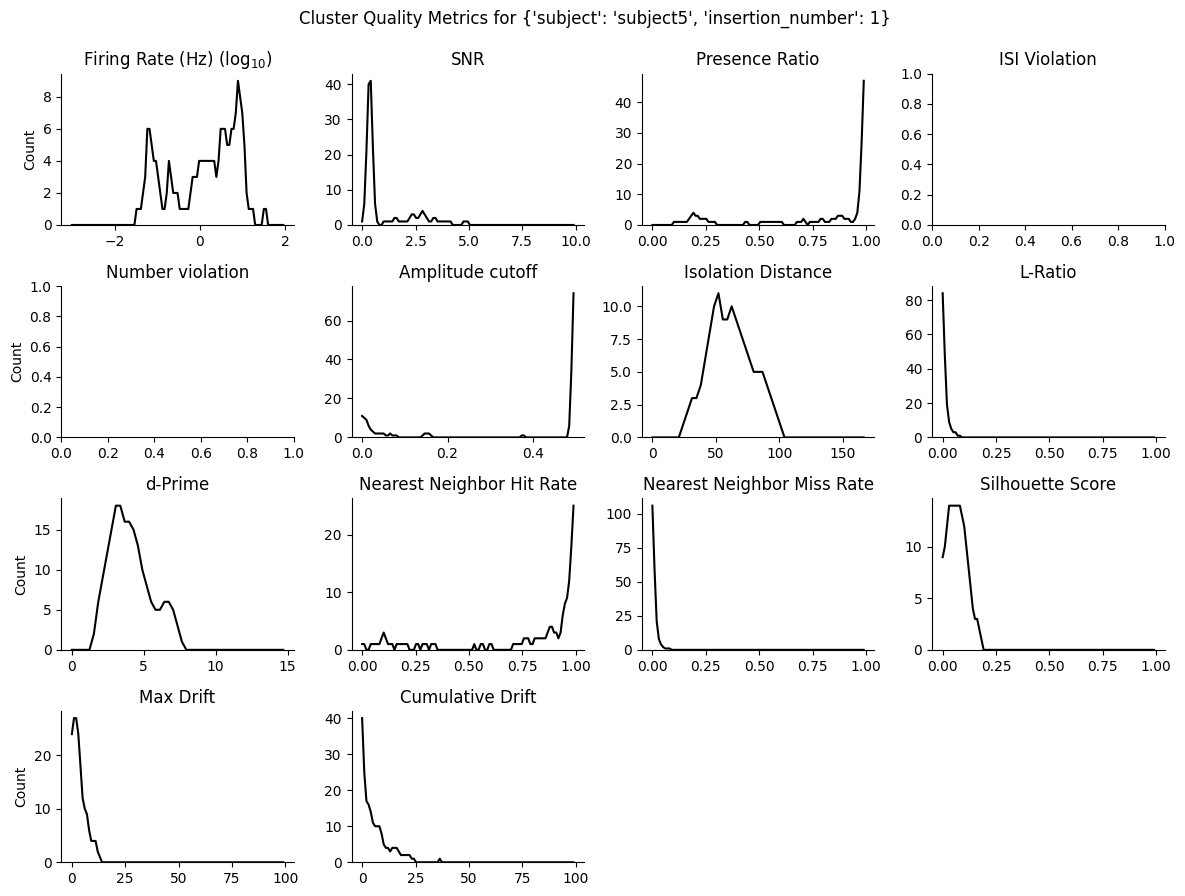

In [4]:
# Plot the results
fig, axes = plt.subplots(4, 4, figsize=(12, 9))
axes = axes.flatten()
plt.suptitle(f"Cluster Quality Metrics for {key}", y=.99, fontsize=12)

# Firing Rates
data = np.log10(query.fetch("firing_rate"))
bins = np.linspace(-3,2,100)
plot_metric(axes[0], data, bins, title="Firing Rate (Hz) (log$_{10}$)")
axes[0].set_ylabel("Count")

# Signal-to-Noise Ratio
data = query.fetch("snr")
bins = np.linspace(0, 10, 100)
plot_metric(axes[1], data, bins, title="SNR")

# Presence Ratio
data = query.fetch("presence_ratio")
bins = np.linspace(0, 1, 100)
plot_metric(axes[2], data, bins, title="Presence Ratio")

# ISI Violation
data = query.fetch("isi_violation")
bins = np.linspace(0, 1, 100)
plot_metric(axes[3], data, bins, title="ISI Violation")

# Number Violation
data = query.fetch("number_violation")
bins = np.linspace(0, 1, 100)
plot_metric(axes[4], data, bins, title="Number violation")
axes[4].set_ylabel("Count")

# Amplitude Cutoff
data = query.fetch("amplitude_cutoff")
bins = np.linspace(0, 0.5, 100)
plot_metric(axes[5], data, bins, title="Amplitude cutoff")

# Isolation Distance
data = query.fetch("isolation_distance")
bins = np.linspace(0, 170, 50)
plot_metric(axes[6], data, bins, title="Isolation Distance")

# Amplitude Cutoff
data = query.fetch("l_ratio")
bins = np.linspace(0, 1, 100)
plot_metric(axes[7], data, bins, title="L-Ratio")

# d-Prime
data = query.fetch("d_prime")
bins = np.linspace(0, 15, 50)
plot_metric(axes[8], data, bins, title="d-Prime")
axes[8].set_ylabel("Count")

# Nearest-Neighbor Hit Rate
data = query.fetch("nn_hit_rate")
bins = np.linspace(0, 1, 100)
plot_metric(axes[9], data, bins, title="Nearest Neighbor Hit Rate")

# Nearest-Neighbor Miss Rate
data = query.fetch("nn_miss_rate")
bins = np.linspace(0, 1, 100)
plot_metric(axes[10], data, bins, title="Nearest Neighbor Miss Rate")

# Silhouette Score
data = query.fetch("silhouette_score")
bins = np.linspace(0, 1, 100)
plot_metric(axes[11], data, bins, title="Silhouette Score")

# Max Drift
data = query.fetch("max_drift")
bins = np.linspace(0, 100, 100)
plot_metric(axes[12], data, bins, title="Max Drift")
axes[12].set_ylabel("Count")

# Cumulative Drift
data = query.fetch("cumulative_drift")
bins = np.linspace(0, 100, 100)
plot_metric(axes[13], data, bins, title="Cumulative Drift")

[ax.remove() for ax in axes[14:]]
plt.tight_layout()

### Waveform quality metrics

- `Amplitude (μV)`: The absolute difference between the waveform peak and trough.

- `Duration (ms)`: The time interval between the waveform peak and trough.

- `PT (peak-to-trough)  Ratio`: The absolute amplitude of the peak divided by the absolute amplitude of the trough relative to 0.

- `Repolarization Slope`: The slope of the fitted regression line to the first 30μs from trough to peak.

- `Recovery Slope`: The slope of the fitted regression line to the first 30μs from peak to tail.

- `Spread (μm)`: The spatial extent of channels where the waveform amplitude exceeds 12% of the maximum amplitude.

- `Velocity Above (s/m)`: The inverse velocity of waveform propagation from the soma toward the top of the probe.

- `Velocity Below (s/m)`: The inverse velocity of waveform propagation from the soma toward the bottom of the probe.

In [5]:
query = ephys.QualityMetrics.Waveform & key
query

subject,session_datetime,insertion_number,paramset_idx,curation_id,unit,amplitude (uV) absolute difference between waveform peak and trough,duration (ms) time between waveform peak and trough,halfwidth (ms) spike width at half max amplitude,pt_ratio absolute amplitude of peak divided by absolute amplitude of trough relative to 0,repolarization_slope the repolarization slope was defined by fitting a regression line to the first 30us from trough to peak,recovery_slope the recovery slope was defined by fitting a regression line to the first 30us from peak to tail,spread (um) the range with amplitude above 12-percent of the maximum amplitude along the probe,velocity_above (s/m) inverse velocity of waveform propagation from the soma toward the top of the probe,velocity_below (s/m) inverse velocity of waveform propagation from the soma toward the bottom of the probe
subject5,2023-04-19 17:52:17,1,1,1,0,120.402,1.08509,nan,0.74622,0.0388668,-0.3638,280.0,0.0735822,-0.0114461
subject5,2023-04-19 17:52:17,1,1,1,1,151.819,1.05762,nan,0.657574,0.0700459,-0.0806154,300.0,-0.0576308,-0.137353
subject5,2023-04-19 17:52:17,1,1,1,2,142.161,0.59062,nan,0.711684,0.175466,-0.119525,300.0,0.081758,-0.0572306
subject5,2023-04-19 17:52:17,1,1,1,3,144.028,1.03015,nan,0.741737,0.0801046,-0.0811708,300.0,-0.138989,0.0711516
subject5,2023-04-19 17:52:17,1,1,1,4,87.3382,0.563149,nan,0.869518,0.189142,-0.0258353,300.0,0.595198,-0.582626
subject5,2023-04-19 17:52:17,1,1,1,5,80.6693,0.508208,nan,0.864687,0.24975,-0.0206796,300.0,-1.13317,1.08081
subject5,2023-04-19 17:52:17,1,1,1,6,86.7877,0.576884,nan,0.834892,0.256677,-0.0614186,300.0,2.34645,0.0654064
subject5,2023-04-19 17:52:17,1,1,1,7,80.8594,0.453266,nan,0.840421,0.212582,-0.0467612,300.0,2.08319,0.228922
subject5,2023-04-19 17:52:17,1,1,1,8,100.313,1.05762,nan,0.800589,0.0222054,-0.518803,300.0,0.173843,-0.0654064
subject5,2023-04-19 17:52:17,1,1,1,9,63.2377,0.576884,nan,0.909614,0.152643,-0.0177585,280.0,1.0138,0.147164


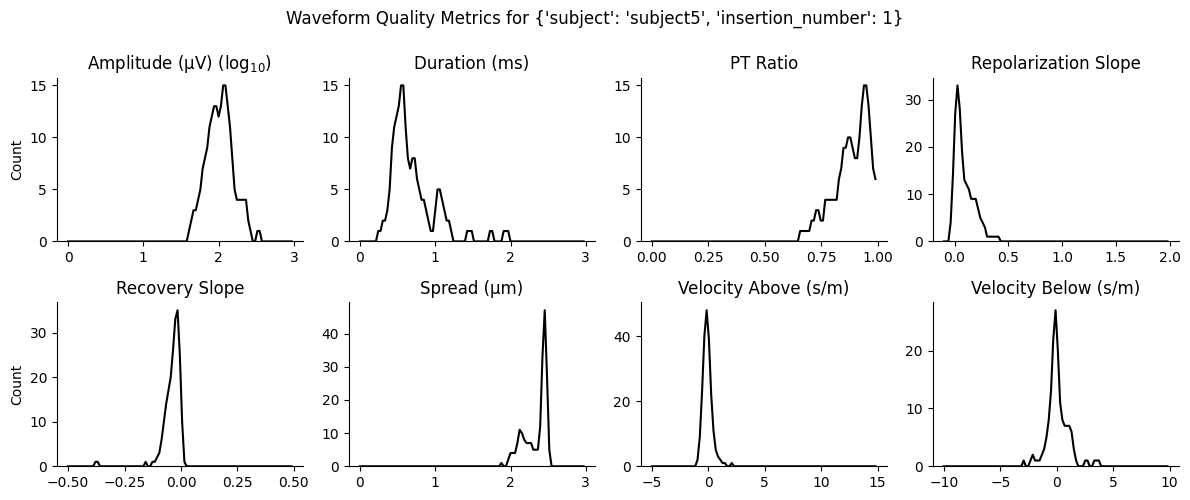

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(12, 5))
axes = axes.flatten()
plt.suptitle(f"Waveform Quality Metrics for {key}", y=.99, fontsize=12)

# Amplitude
data = np.log10(query.fetch("amplitude"))
bins = np.linspace(0, 3, 100)
plot_metric(axes[0], data, bins, title="Amplitude (μV) (log$_{10}$)")
axes[0].set_ylabel("Count")

# Duration
data = query.fetch("duration")
bins = np.linspace(0, 3, 100)
plot_metric(axes[1], data, bins, title="Duration (ms)")

# PT Ratio
data = query.fetch("pt_ratio")
bins = np.linspace(0, 1, 100)
plot_metric(axes[2], data, bins, title="PT Ratio")

# Repolarization Slope
data = query.fetch("repolarization_slope")
bins = np.linspace(-0.1, 2, 100)
plot_metric(axes[3], data, bins, title="Repolarization Slope")

# Recovery Slope
data = query.fetch("recovery_slope")
bins = np.linspace(-0.5, 0.5, 100)
plot_metric(axes[4], data, bins, title="Recovery Slope")
axes[4].set_ylabel("Count")

# Spread
data = np.log10(query.fetch("spread"))
bins = np.linspace(0, 3, 100)
plot_metric(axes[5], data, bins, title="Spread (μm)")

# Velocity Above
data = query.fetch("velocity_above")
bins = np.linspace(-5, 15, 100)
plot_metric(axes[6], data, bins, title="Velocity Above (s/m)")

# Velocity Below
data = query.fetch("velocity_below")
bins = np.linspace(-10, 10, 100)
plot_metric(axes[7], data, bins, title="Velocity Below (s/m)")
plt.tight_layout()